In [1]:
using FKTcheb
using SymPy
using TimerOutputs
using LinearAlgebra
using LowRankApprox
using Printf
using Random
using Plots
using Distributions
using StaticArrays
using Polynomials
using SpecialFunctions
using Combinatorics

┌ Info: Precompiling FKTcheb [8f6a1ce6-3be6-48da-82a4-714bd5a66102]
└ @ Base loading.jl:1317
┌ Warning: Package FKTcheb does not have Plots in its dependencies:
│ - If you have FKTcheb checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FKTcheb
└ Loading Plots into FKTcheb from project dependency, future warnings for FKTcheb are suppressed.


In [2]:
include("factor.jl")
include("util.jl")
include("gegenbauer.jl")
include("hyperspherical.jl")

hypospherical (generic function with 1 method)

In [6]:

r = Sym("r")

spread_param = 2
dct_n         = 100 # Iterations for discrete cosine transform
kern          = 1 / (1+r^2)
mat_kern(x,y) = 1 / (1+norm(x-y)^2)
lkern         = lambdify(kern)
to            = TimerOutput()


results = Dict()
for num_points in 50000:50000:250000
    random_samp = randperm(num_points)[1:1000]
    for d in 3:4:15
        x_vecs = [rand(d) / spread_param for _ in 1:num_points]
        truth_mat  = mat_kern.(x_vecs[random_samp], permutedims(x_vecs[random_samp]))
        truemat_frobnorm = norm(truth_mat)
        for fkt_deg in 2:2:10
            GC.gc()
            println((num_points, d, fkt_deg))
            rtol = 10.0^(-15)
            cfg = fkt_config(fkt_deg, d, dct_n, to, rtol)
            rtol = guess_fkt_err(lkern, x_vecs, cfg)
            cfg = fkt_config(fkt_deg, d, dct_n, to, rtol)
            fkt_t = 0
            U_mat=0
            for k in 1:3
                fkt_t += @elapsed U_mat = degen_kern_harmonic(lkern, x_vecs, cfg)
            end
            fkt_t/=3
            V_mat = transpose(U_mat)
            fkt_rank = size(U_mat, 2)

            fkt_guess = U_mat[random_samp,:]*V_mat[:, random_samp]
            fkt_err = (norm(fkt_guess-truth_mat)
                            /truemat_frobnorm)
            results[(num_points, d, fkt_deg)] = (fkt_t, fkt_rank, fkt_err)
        end
    end
end



(50000, 3, 2)
(50000, 3, 4)
(50000, 3, 6)
(50000, 3, 8)
(50000, 3, 10)
(50000, 7, 2)
(50000, 7, 4)
(50000, 7, 6)
(50000, 7, 8)
(50000, 7, 10)
(50000, 11, 2)
(50000, 11, 4)
(50000, 11, 6)
(50000, 11, 8)
(50000, 11, 10)
(50000, 15, 2)
(50000, 15, 4)
(50000, 15, 6)
(50000, 15, 8)
(50000, 15, 10)
(100000, 3, 2)
(100000, 3, 4)
(100000, 3, 6)
(100000, 3, 8)
(100000, 3, 10)
(100000, 7, 2)
(100000, 7, 4)
(100000, 7, 6)
(100000, 7, 8)
(100000, 7, 10)
(100000, 11, 2)
(100000, 11, 4)
(100000, 11, 6)
(100000, 11, 8)
(100000, 11, 10)
(100000, 15, 2)
(100000, 15, 4)
(100000, 15, 6)
(100000, 15, 8)
(100000, 15, 10)
(150000, 3, 2)
(150000, 3, 4)
(150000, 3, 6)
(150000, 3, 8)
(150000, 3, 10)
(150000, 7, 2)
(150000, 7, 4)
(150000, 7, 6)
(150000, 7, 8)
(150000, 7, 10)
(150000, 11, 2)
(150000, 11, 4)
(150000, 11, 6)
(150000, 11, 8)
(150000, 11, 10)
(150000, 15, 2)
(150000, 15, 4)
(150000, 15, 6)
(150000, 15, 8)
(150000, 15, 10)
(200000, 3, 2)
(200000, 3, 4)
(200000, 3, 6)
(200000, 3, 8)
(200000, 3, 10)
(2

In [ ]:
results

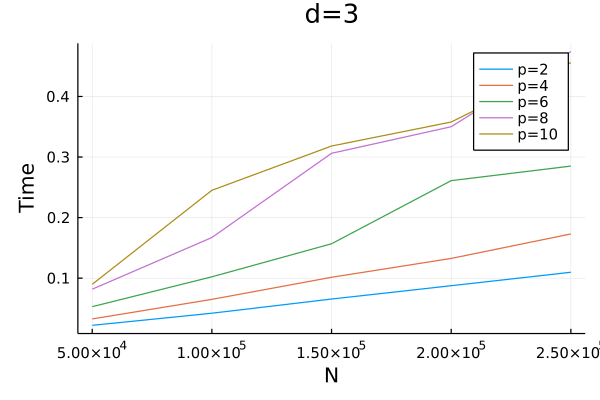

In [7]:
ns = collect(50000:50000:250000)
all_times = []
for p in 2:2:10
    times = []
    for n in ns
        push!(times, results[(n, 3, p)][1])
    end
    push!(all_times, times)
end
p = plot(title="d=3", thickness_scaling = 1.25, xlabel="N", ylabel="Time")
for k in 1:length(all_times)
    p=plot!(ns, all_times[k], label=string("p=",2*k))
end
p

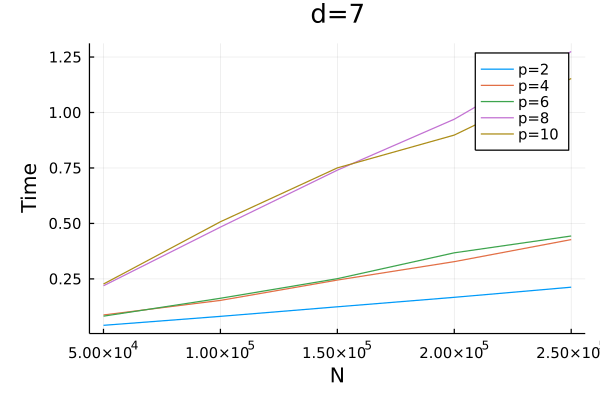

In [8]:
ns = collect(50000:50000:250000)
all_times = []
for p in 2:2:10
    times = []
    for n in ns
        push!(times, results[(n, 7, p)][1])
    end
    push!(all_times, times)
end
p = plot(title="d=7")
for k in 1:length(all_times)
    p=plot!(ns, all_times[k], label=string("p=",2*k), thickness_scaling = 1.25, xlabel="N", ylabel="Time")
end
p

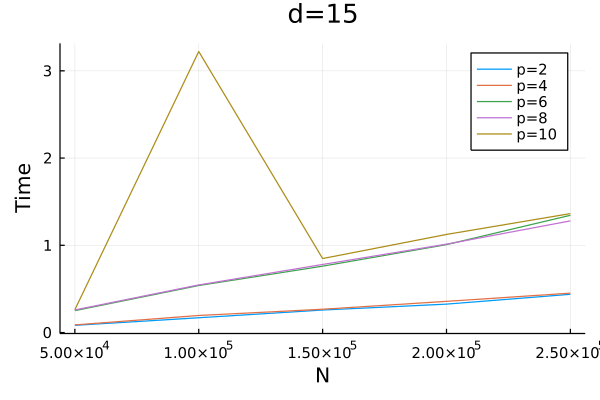

In [9]:
ns = collect(50000:50000:250000)
all_times = []
for p in 2:2:10
    times = []
    for n in ns
        push!(times, results[(n, 15, p)][1])
    end
    push!(all_times, times)
end
p = plot(title="d=15")
for k in 1:length(all_times)
    p=plot!(ns, all_times[k], label=string("p=",2*k), thickness_scaling = 1.25, xlabel="N", ylabel="Time")
end
p

In [10]:
n = 200_000
d_to_nystrom_times = Dict()
d_to_nystrom_ranks = Dict()
d_to_nystrom_errs = Dict()
for d in 3:4:15
    nystrom_times = []
    nystrom_ranks = []
    nystrom_errs  = []

    random_samp = randperm(num_points)[1:1000]
    x_vecs = [rand(d) / spread_param for _ in 1:num_points]
    truth_mat  = mat_kern.(x_vecs[random_samp], permutedims(x_vecs[random_samp]))
    truemat_frobnorm = norm(truth_mat)
    for idrnk in 1:10:100
        q_set = randperm(length(x_vecs))[1:idrnk]
        GC.gc()
        nystrom_t = @elapsed begin
            Nq =  mat_kern.(x_vecs, permutedims(x_vecs[q_set]))
            qmat = lu( mat_kern.(x_vecs[q_set], permutedims(x_vecs[q_set])))
        end

        # Get error for Nystrom
        nystrom_guess = Nq[random_samp,:] * (qmat \ transpose(Nq[random_samp,:]))

        push!(nystrom_ranks, idrnk)
        push!(nystrom_errs, norm(nystrom_guess-truth_mat)/truemat_frobnorm)
        push!(nystrom_times, nystrom_t)
        # println("Nystrom r=",idrnk, ", err=", nystromerror)
    end
    d_to_nystrom_times[d] = nystrom_times
    d_to_nystrom_errs[d] = nystrom_errs
    d_to_nystrom_ranks[d] = nystrom_ranks
end

LoadError: UndefVarError: num_points not defined

In [11]:
ps = collect(2:2:10)
all_times = []
n = 200_000
d = 3

times = []
accs = []
ranks = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title="d=3, n=200000")

p = plot!(accs, times, xlabel="Rel acc", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_times[d], label="Nystrom")


LoadError: KeyError: key 3 not found

In [12]:
ps = collect(2:2:10)
all_times = []
n = 200000
d = 7

times = []
accs = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
end
p = plot(title="d=7, n=200000")

p = plot!(accs, times, xlabel="Rel acc", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_times[d], label="Nystrom")


LoadError: KeyError: key 7 not found

In [13]:
ps = collect(2:2:10)
all_times = []
n = 200000
d = 15

times = []
accs = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
end
p = plot(title="d=15, n=200000")

p = plot!(accs, times, xlabel="Rel acc", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_times[d], label="Nystrom")


LoadError: KeyError: key 15 not found

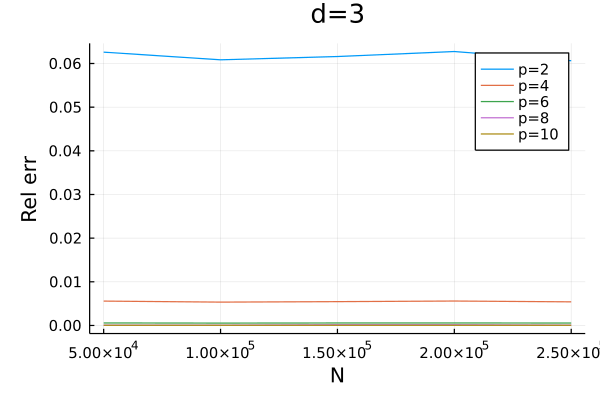

In [14]:
ns = collect(50000:50000:250000)
d=3

all_errs = []
for p in 2:2:10
    errs = []
    for n in ns
        push!(errs, results[(n, d, p)][3])
    end
    push!(all_errs, errs)
end
p = plot(title="d=3", thickness_scaling = 1.25, xlabel="N", ylabel="Rel err")
for k in 1:length(all_errs)
    p=plot!(ns, all_errs[k], label=string("p=",2*k))
end
p

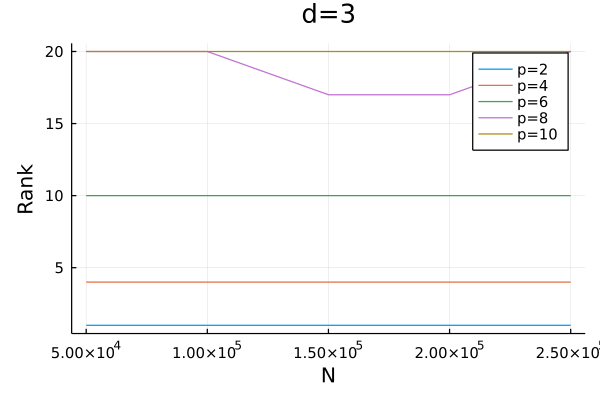

In [15]:
ns = collect(50000:50000:250000)
d=3

all_ranks = []
for p in 2:2:10
    ranks = []
    for n in ns
        push!(ranks, results[(n, d, p)][2])
    end
    push!(all_ranks, ranks)
end
p = plot(title="d=3", thickness_scaling = 1.25, xlabel="N", ylabel="Rank")
for k in 1:length(all_ranks)
    p=plot!(ns, all_ranks[k], label=string("p=",2*k))
end
p

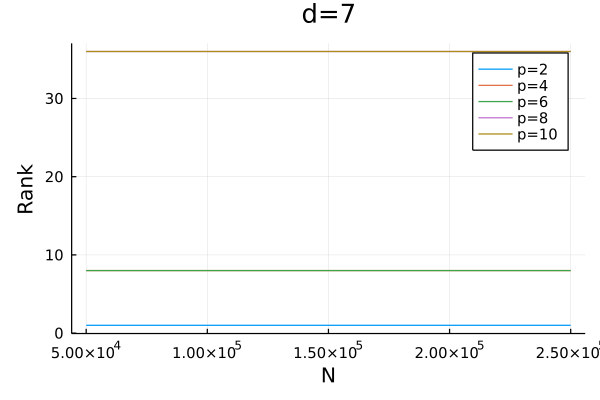

In [16]:
ns = collect(50000:50000:250000)
d=7

all_ranks = []
for p in 2:2:10
    ranks = []
    for n in ns
        push!(ranks, results[(n, d, p)][2])
    end
    push!(all_ranks, ranks)
end
p = plot(title=string("d=",d), thickness_scaling = 1.25, xlabel="N", ylabel="Rank")
for k in 1:length(all_ranks)
    p=plot!(ns, all_ranks[k], label=string("p=",2*k))
end
p

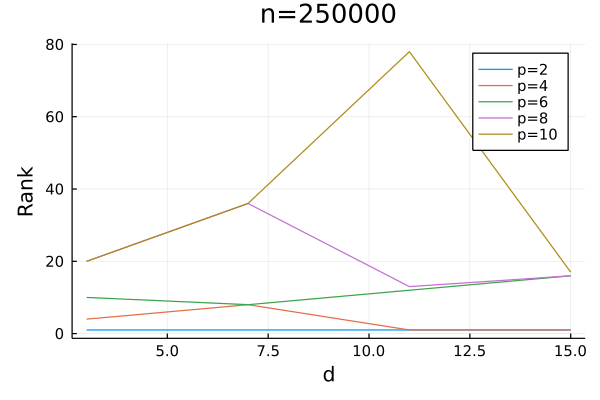

In [17]:
n = 250_000
ds = collect(3:4:15)
all_ys = []
for p in 2:2:10
    ys = []
    for d in ds
        push!(ys, results[(n, d, p)][2])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="d", ylabel="Rank")
for k in 1:length(all_ys)
    p=plot!(ds, all_ys[k], label=string("p=",2*k))
end
p

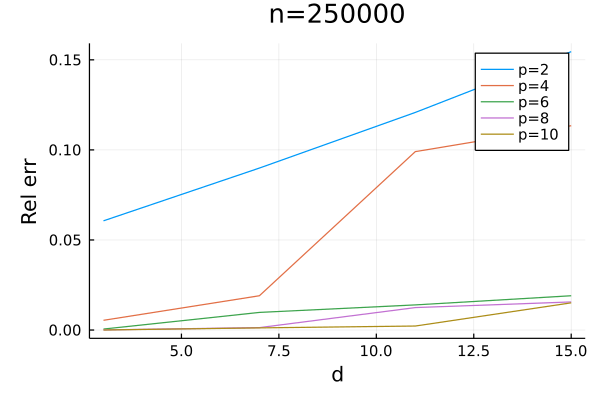

In [18]:
n = 250_000
ds = collect(3:4:15)
all_ys = []
for p in 2:2:10
    ys = []
    for d in ds
        push!(ys, results[(n, d, p)][3])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="d", ylabel="Rel err")
for k in 1:length(all_ys)
    p=plot!(ds, all_ys[k], label=string("p=",2*k))
end
p

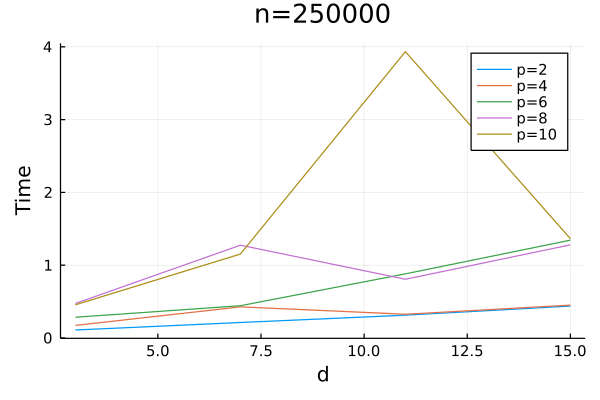

In [19]:
n = 250_000
ds = collect(3:4:15)
all_ys = []
for p in 2:2:10
    ys = []
    for d in ds
        push!(ys, results[(n, d, p)][1])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="d", ylabel="Time")
for k in 1:length(all_ys)
    p=plot!(ds, all_ys[k], label=string("p=",2*k))
end
p

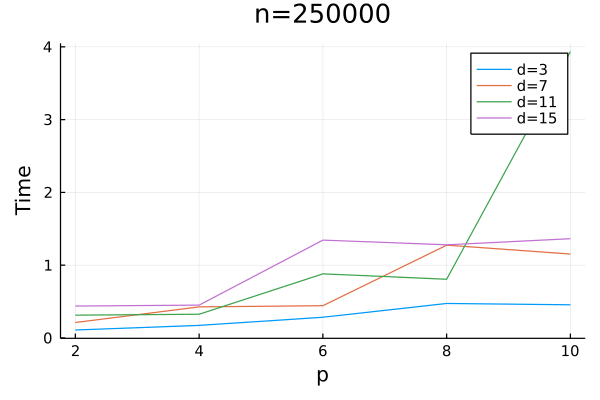

In [20]:
n = 250_000
ps = collect(2:2:10)
all_ys = []
for d in 3:4:15
    ys = []
    for p in ps
        push!(ys, results[(n, d, p)][1])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="p", ylabel="Time")
for k in 1:length(all_ys)
    p=plot!(ps, all_ys[k], label=string("d=",4k-1))
end
p

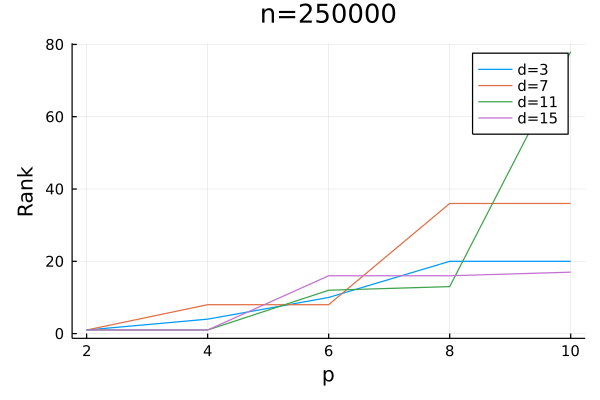

In [21]:
n = 250_000
ps = collect(2:2:10)
all_ys = []
for d in 3:4:15
    ys = []
    for p in ps
        push!(ys, results[(n, d, p)][2])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="p", ylabel="Rank")
for k in 1:length(all_ys)
    p=plot!(ps, all_ys[k], label=string("d=",4k-1))
end
p

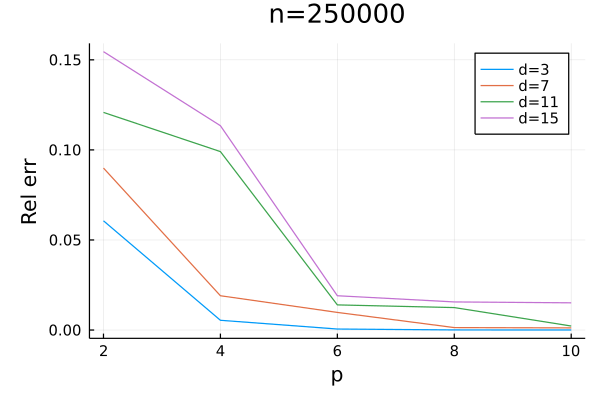

In [22]:
n = 250_000
ps = collect(2:2:10)
all_ys = []
for d in 3:4:15
    ys = []
    for p in ps
        push!(ys, results[(n, d, p)][3])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="p", ylabel="Rel err")
for k in 1:length(all_ys)
    p=plot!(ps, all_ys[k], label=string("d=",4k-1))
end
p

In [23]:
ps = collect(2:2:10)
all_times = []
n = 250_000
d = 3

times = []
accs = []
ranks = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title="d=3, n=250000")

p = plot!(accs, ranks, xlabel="Rel acc", ylabel="Rank", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_ranks[d], label="Nystrom")


LoadError: KeyError: key 3 not found

In [24]:
ps = collect(2:2:10)
all_times = []
n = 250_000
d = 15

times = []
accs = []
ranks = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title=string("d=",d," n=", n))

p = plot!(accs, ranks, xlabel="Rel acc", ylabel="Rank", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_ranks[d], label="Nystrom")


LoadError: KeyError: key 15 not found

In [25]:
ps = collect(2:2:10)
all_times = []
n = 250_000
d = 3

times = []
accs = []
ranks = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title=string("d=",d," n=", n))

p = plot!(ranks, times, xlabel="Rank", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_ranks[d], d_to_nystrom_times[d], label="Nystrom")


LoadError: KeyError: key 3 not found

In [26]:
ps = collect(2:2:10)
all_times = []
n = 250_000
d = 15

times = []
accs = []
ranks = []

for p in collect(2:2:10)
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title=string("d=",d," n=", n))

p = plot!(ranks, times, xlabel="Rank", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_ranks[d], d_to_nystrom_times[d], label="Nystrom")


LoadError: KeyError: key 15 not found